패키지 설치

In [ ]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install fasttext

In [4]:
# pre-trained data: fasttext 가져오기
import fasttext
import fasttext.util

In [5]:
fasttext.util.download_model('ko', if_exists='ignore') # 존재하면 무시
ft = fasttext.load_model('cc.ko.300.bin')

In [6]:
# fast_words - fasttext 단어들, 에러 replace
fast_words = ft.get_words(on_unicode_error='replace')

In [7]:
len(fast_words)

2000000

모듈 import

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, os
import json
%matplotlib inline

import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import Constant
from keras import optimizers
from keras import regularizers

from tqdm import tqdm
from collections import Counter

from konlpy.tag import Mecab

데이터 불러오기

In [9]:
# 데이터 호출 
train_data = pd.read_table('/content/drive/MyDrive/DACON/ratings_train.txt', encoding='utf-8')
test_data = pd.read_table('/content/drive/MyDrive/DACON/ratings_test.txt', encoding='utf-8')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


EDA

In [10]:
# 데이터 shape 확인(리뷰 수)
train_data.shape, test_data.shape

((150000, 3), (50000, 3))

In [11]:
train_data.nunique()

id          150000
document    146182
label            2
dtype: int64

In [12]:
# 각 review의 길이
train_length = train_data['document'].astype(str).apply(len)
train_length.head()

0    19
1    33
2    17
3    29
4    61
Name: document, dtype: int64

In [13]:
# maxlen 구하기 위함
print(f'리뷰 길이 최댓값 : {np.max(train_length)}')
print(f'리뷰 길이 최솟값 : {np.min(train_length)}')
print(f'리뷰 길이 평균값 : {np.mean(train_length)}')
print(f'리뷰 길이 표준편차 : {np.std(train_length)}')
print(f'리뷰 길이 중간값 : {np.median(train_length)}')

리뷰 길이 최댓값 : 146
리뷰 길이 최솟값 : 1
리뷰 길이 평균값 : 35.203453333333336
리뷰 길이 표준편차 : 29.531884578220215
리뷰 길이 중간값 : 27.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


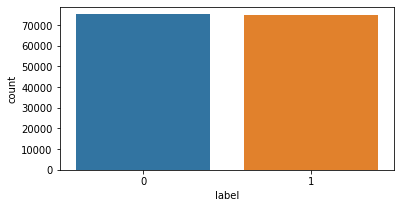

In [14]:
# train data의 긍정 및 부정 비율
fig, ax = plt.subplots(ncols=1)
fig.set_size_inches(6,3)
sns.countplot(train_data['label'])

In [15]:
print(f"긍정 리뷰 개수 : {train_data['label'].value_counts()[1]}")
print(f"부정 리뷰 개수 : {train_data['label'].value_counts()[0]}")

긍정 리뷰 개수 : 74827
부정 리뷰 개수 : 75173


# 전처리

1. 전처리 함수 정의

In [16]:
def preprocessing(review, mecab, remove_stopwords=False, stop_words=[]):
    # 한글 자모 빼고 제거 - 논문에서 특수문자가 의미 가진다는 결과 있어서 특수문자는 빼지 않음
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", review)
    word_review = mecab.morphs(review_text)

    # 불용어 제거
    if remove_stopwords:
        word_review = [token for token in word_review if not token in stop_words]
    
    return word_review

In [17]:
# 결측치 먼저 제거하기 위함
train_data['document'].str.replace("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "")
train_data['document'][:5]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


0                                  아 더빙.. 진짜 짜증나네요 목소리
1                    흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                    너무재밓었다그래서보는것을추천한다
3                        교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4    사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
Name: document, dtype: object

In [18]:
# 결측치 먼저 제거하기 위함
train_data['document'].replace('', np.nan, inplace=True)
train_data.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [19]:
# 결측치 먼저 제거하기 위함
train_data = train_data.dropna(how='any')
print(len(train_data))

149995


In [20]:
test_data['document'].str.replace("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "")

test_data.isnull().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


id          0
document    3
label       0
dtype: int64

In [21]:
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')
print(len(test_data))

49997


2. 전처리

In [22]:
stop_words = set(['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','아']) # 불용어 설정
mecab = Mecab()

# 정제된 train_review
clean_train_review = []

for review in train_data['document']:
    if type(review) == str:
        clean_train_review.append(preprocessing(review, mecab, remove_stopwords=True, stop_words=stop_words))
    else:
        clean_train_review.append([])

In [23]:
clean_train_review[:3]

[['더', '빙', '진짜', '짜증', '나', '네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'],
 ['너무', '재', '밓었다그래서보는것을추천한다']]

In [24]:
# 정제된 test review
clean_test_review = []

for review in test_data['document']:
    if type(review) == str:
        clean_test_review.append(preprocessing(review, mecab, remove_stopwords=True, stop_words=stop_words))
    else:
        clean_test_review.append([])

In [25]:
clean_test_review[:3]

[['굳', 'ㅋ'],
 [],
 ['뭐', '야', '평점', '나쁘', '진', '않', '지만', '점', '짜리', '더더욱', '아니', '잖아']]

3. 토큰화

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_review)
# texts_to_sequences: 텍스트 내 단어들 숫자 시퀀스 형태로 변환
train_sequences = tokenizer.texts_to_sequences(clean_train_review)
test_sequences = tokenizer.texts_to_sequences(clean_test_review)

word_vocab = tokenizer.word_index

In [27]:
# 정제된 전체 데이터셋 내 토큰 개수(문장 길이) 분포 살펴보기
total_data_text = list(clean_train_review) + list(clean_test_review)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('평균 문장 길이 : ', np.mean(num_tokens))
print('최대 문장 길이 : ', np.max(num_tokens))
print('문장 길이 표준 편차 : ', np.std(num_tokens))

평균 문장 길이 :  13.387665506620264
최대 문장 길이 :  83
문장 길이 표준 편차 :  11.435601094181893


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


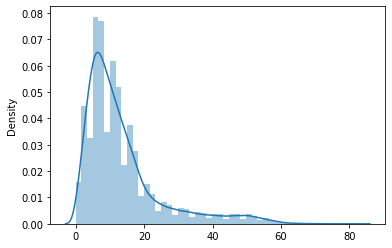

In [28]:
# 문장 길이 분포
sns.distplot(num_tokens)

In [29]:
# maxlen 설정 위한 확인과정
max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
maxlen = int(max_tokens)

print('MAX_SEQUENCE_LENGTH : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens) * 100}%가 maxlen 설정값 이내에 포함')

MAX_SEQUENCE_LENGTH :  47
전체 문장의 97.08838353534142%가 maxlen 설정값 이내에 포함


4. 패딩

In [30]:
MAX_SEQUENCE_LENGTH = 47 # 문장 최대 길이

# pad_sequences: 0 이용하여 같은 길이의 시퀀스로 변환
train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='pre')
train_labels = np.array(train_data['label'])
test_inputs = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='pre')
test_labels = np.array(test_data['label'])

In [31]:
train_inputs.shape, test_inputs.shape

((149995, 47), (49997, 47))

In [32]:
# key값으로 단어 가져오기 위해 index_to_word도 생성
index_to_word = {index:word for word, index in word_vocab.items()}

5. Embedding matrix 생성

In [33]:
len(word_vocab)

49945

In [34]:
vocab_size = len(word_vocab)  # 어휘 사전의 크기
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 임베딩 틀 잡기
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# 앞부분 특수문자 제외 & 우리가 만든 단어사전 단어가 fast_words에 있다면 임베딩 매트릭스에 해당 단어 채워넣기
for i in range(1, vocab_size):
    if index_to_word[i] in fast_words:
        embedding_matrix[i] = ft[index_to_word[i]]

In [35]:
len(embedding_matrix)

49945

6. 토큰화한 데이터 저장

In [36]:
import json

data_path = '/content/drive/MyDrive/DACON/'
train_input_data = 'nsmc_train_input.npy'
train_label_data = 'nsmc_train_label.npy'
test_input_data = 'nsmc_test_input.npy'
test_label_data = 'nsmc_test_label.npy'
embedd = 'nsmc_embbedding_matrix.npy'
Data_configs = 'data_configs.json'

data_configs = {}
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(embedding_matrix)+1

# numpy 파일로 저장
np.save(open(data_path + train_input_data, 'wb'), train_inputs)
np.save(open(data_path + train_label_data, 'wb'), train_labels)

np.save(open(data_path + test_input_data, 'wb'), test_inputs)
np.save(open(data_path + test_label_data, 'wb'), test_labels)

np.save(open(data_path + embedd, 'wb'), embedding_matrix)

# 단어 사전 json으로 저장
json.dump(data_configs, open(data_path + Data_configs, 'w'), ensure_ascii=False)

In [37]:
# fasttext 램 줄이기
del ft

# CNN-non-static

1. 모델 생성

In [38]:
from tensorflow.keras.initializers import Constant

# Sequential 모델 구성
# Functional API 돌려봤는데 Sequential이 성능 더 좋았음
nonst = Sequential()
# Embedding: (vocab_size, word_vector_dim) 차원에 입력 벡터 뿌리기
# trainable: True는 non-static, False는 static
# non-static: task마다 벡터값 update(fine-tuning)
nonst.add(Embedding(vocab_size, 
                    word_vector_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=True))
nonst.add(Conv1D(32, 7, activation='relu'))
nonst.add(MaxPooling1D(5))
nonst.add(Conv1D(32, 7, activation='relu'))
nonst.add(GlobalMaxPooling1D())
nonst.add(Dropout(0.5))
nonst.add(Dense(16, activation='relu'))
nonst.add(Dense(1, activation='sigmoid'))

nonst.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 47, 300)           14983500  
                                                                 
 conv1d (Conv1D)             (None, 41, 32)            67232     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 32)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 32)             7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 32)                0

2. 모델 compile - 모델 학습 위한 학습과정 설정

In [39]:
nonst.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

3. callback - checkpoint, earlystopping

In [40]:
MODEL_SAVE_FOLDER = '/content/drive/MyDrive/DACON'
model_path = f"{MODEL_SAVE_FOLDER}mmist-{{epoch:d}}-{{val_loss:.5f}}-{{val_accuracy:.5f}}.hdf5"

cb_checkpoint = ModelCheckpoint(filepath=model_path, 
                                monitor='val_accuracy',
                                save_weights_only=True,
                                verbose=1,
                                save_best_only=True)
cb_early_stopping= EarlyStopping(monitor='val_accuracy',min_delta=0.0001, patience=4) # did not imporoved가 연속으로 4번 나오면 학습 stop

4. train과 validation set 분리

In [41]:
# validation set 30000건 분리(전체 data의 약 20%)
X_val = train_inputs[:30000]   
y_val = train_labels[:30000]

# validation set을 제외한 나머지 118182건
partial_X_train = train_inputs[30000:]  
partial_y_train = train_labels[30000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(119995, 47)
(119995,)


5. 모델 학습

In [42]:
epochs = 20

hist = nonst.fit(partial_X_train, partial_y_train, 
                 batch_size=256, epochs=epochs, validation_data=(X_val, y_val), 
                 callbacks=[cb_early_stopping, cb_checkpoint])

Epoch 1/20
469/469 [==============================] - ETA: 0s - loss: 0.5254 - accuracy: 0.7127
Epoch 1: val_accuracy improved from -inf to 0.82313, saving model to /content/drive/MyDrive/DACONmmist-1-0.39126-0.82313.hdf5
469/469 [==============================] - 31s 26ms/step - loss: 0.5254 - accuracy: 0.7127 - val_loss: 0.3913 - val_accuracy: 0.8231
Epoch 2/20
468/469 [============================>.] - ETA: 0s - loss: 0.3636 - accuracy: 0.8405
Epoch 2: val_accuracy improved from 0.82313 to 0.83023, saving model to /content/drive/MyDrive/DACONmmist-2-0.37055-0.83023.hdf5
469/469 [==============================] - 12s 25ms/step - loss: 0.3636 - accuracy: 0.8406 - val_loss: 0.3705 - val_accuracy: 0.8302
Epoch 3/20
469/469 [==============================] - ETA: 0s - loss: 0.2977 - accuracy: 0.8751
Epoch 3: val_accuracy improved from 0.83023 to 0.83213, saving model to /content/drive/MyDrive/DACONmmist-3-0.37711-0.83213.hdf5
469/469 [==============================] - 12s 25ms/step - los

6. accuracy, loss 그래프 시각화

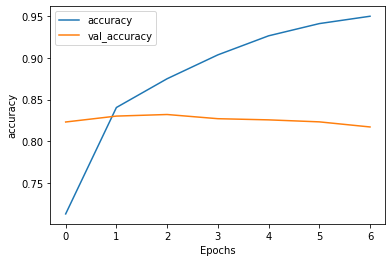

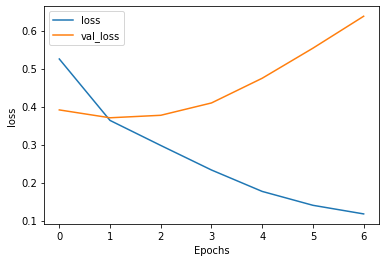

In [43]:
def plot_graphs(hist, string):
    plt.plot(hist.history[string])
    plt.plot(hist.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(hist, 'accuracy')
plot_graphs(hist, 'loss')
# 초반 train에 과적합돼서 valid loss는 커지게 됨

7. 모델 저장

In [44]:
nonst.save("nonstatic_model")

INFO:tensorflow:Assets written to: nonstatic_model/assets


8. 모델 평가

In [45]:
# test set에 모델 적용 - 81.16%
nonst.evaluate(test_inputs, test_labels)

1563/1563 [==============================] - 7s 4ms/step - loss: 0.6585 - accuracy: 0.8116


[0.6584598422050476, 0.8116487264633179]

# CNN-static

In [46]:
static = Sequential()
static.add(Embedding(vocab_size, 
                    word_vector_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=False))
static.add(Conv1D(32, 7, activation='relu'))
static.add(MaxPooling1D(5))
static.add(Conv1D(32, 7, activation='relu'))
static.add(GlobalMaxPooling1D())
static.add(Dropout(0.5))
static.add(Dense(16, activation='relu'))
static.add(Dense(1, activation='sigmoid'))

static.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 47, 300)           14983500  
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 32)            67232     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 8, 32)            0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 2, 32)             7200      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 32)               

In [47]:
static.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [48]:
epochs = 20

hist2 = static.fit(partial_X_train, partial_y_train, 
                 batch_size=256, epochs=epochs, validation_data=(X_val, y_val), 
                 callbacks=[cb_early_stopping, cb_checkpoint])

Epoch 1/20
469/469 [==============================] - ETA: 0s - loss: 0.5942 - accuracy: 0.6648
Epoch 1: val_accuracy did not improve from 0.83213
469/469 [==============================] - 6s 11ms/step - loss: 0.5942 - accuracy: 0.6648 - val_loss: 0.5089 - val_accuracy: 0.7359
Epoch 2/20
467/469 [============================>.] - ETA: 0s - loss: 0.4951 - accuracy: 0.7583
Epoch 2: val_accuracy did not improve from 0.83213
469/469 [==============================] - 5s 11ms/step - loss: 0.4949 - accuracy: 0.7583 - val_loss: 0.4771 - val_accuracy: 0.7688
Epoch 3/20
469/469 [==============================] - ETA: 0s - loss: 0.4559 - accuracy: 0.7825
Epoch 3: val_accuracy did not improve from 0.83213
469/469 [==============================] - 5s 12ms/step - loss: 0.4559 - accuracy: 0.7825 - val_loss: 0.4563 - val_accuracy: 0.7807
Epoch 4/20
466/469 [============================>.] - ETA: 0s - loss: 0.4261 - accuracy: 0.8015
Epoch 4: val_accuracy did not improve from 0.83213
469/469 [=======

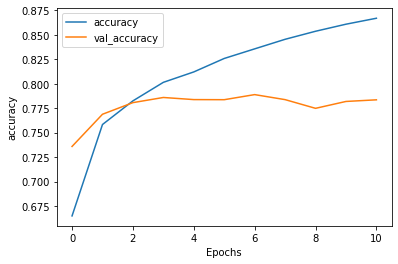

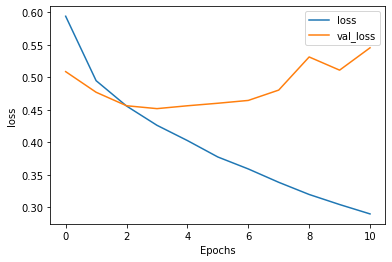

In [49]:
def plot_graphs(hist, string):
    plt.plot(hist2.history[string])
    plt.plot(hist2.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(hist2, 'accuracy')
plot_graphs(hist2, 'loss')
# 초반 train에 과적합돼서 valid loss는 커지게 됨

In [50]:
static.save("static_cnn")

INFO:tensorflow:Assets written to: static_cnn/assets


In [51]:
# test set에 모델 적용 - 78.03%
results = static.evaluate(test_inputs, test_labels)

print(results)

1563/1563 [==============================] - 6s 4ms/step - loss: 0.5557 - accuracy: 0.7803
[0.5557475686073303, 0.7803268432617188]


# CNN-rand

In [54]:
rand = Sequential()
rand.add(Embedding(vocab_size, word_vector_dim))
rand.add(Conv1D(32, 7, activation='relu'))
rand.add(MaxPooling1D(5))
rand.add(Conv1D(32, 7, activation='relu'))
rand.add(GlobalMaxPooling1D())
rand.add(Dropout(0.5))
rand.add(Dense(16, activation='relu'))
rand.add(Dense(1, activation='sigmoid'))

rand.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 300)         14983500  
                                                                 
 conv1d_6 (Conv1D)           (None, None, 32)          67232     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, None, 32)          7200      
                                                                 
 global_max_pooling1d_3 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 32)               

In [55]:
rand.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [58]:
epochs = 20

hist3 = rand.fit(partial_X_train, partial_y_train, 
                 batch_size=256, epochs=epochs, validation_data=(X_val, y_val), 
                 callbacks=[cb_early_stopping, cb_checkpoint])

Epoch 1/20
467/469 [============================>.] - ETA: 0s - loss: 0.4627 - accuracy: 0.7699
Epoch 1: val_accuracy did not improve from 0.83213
469/469 [==============================] - 15s 27ms/step - loss: 0.4626 - accuracy: 0.7700 - val_loss: 0.3713 - val_accuracy: 0.8272
Epoch 2/20
469/469 [==============================] - ETA: 0s - loss: 0.3152 - accuracy: 0.8657
Epoch 2: val_accuracy improved from 0.83213 to 0.83447, saving model to /content/drive/MyDrive/DACONmmist-2-0.36161-0.83447.hdf5
469/469 [==============================] - 12s 25ms/step - loss: 0.3152 - accuracy: 0.8657 - val_loss: 0.3616 - val_accuracy: 0.8345
Epoch 3/20
467/469 [============================>.] - ETA: 0s - loss: 0.2190 - accuracy: 0.9096
Epoch 3: val_accuracy did not improve from 0.83447
469/469 [==============================] - 13s 28ms/step - loss: 0.2191 - accuracy: 0.9096 - val_loss: 0.4066 - val_accuracy: 0.8289
Epoch 4/20
469/469 [==============================] - ETA: 0s - loss: 0.1535 - acc

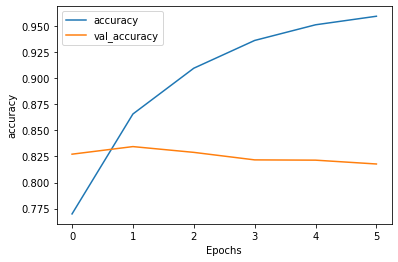

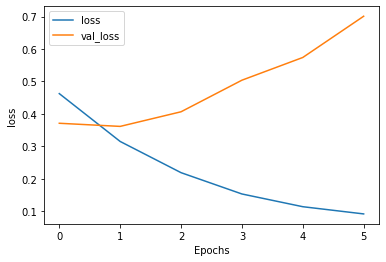

In [59]:
def plot_graphs(hist, string):
    plt.plot(hist3.history[string])
    plt.plot(hist3.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(hist3, 'accuracy')
plot_graphs(hist3, 'loss')

In [60]:
# test set에 모델 적용 - 81.49%
results = rand.evaluate(test_inputs, test_labels)

print(results)

1563/1563 [==============================] - 7s 5ms/step - loss: 0.7128 - accuracy: 0.8149
[0.7127788662910461, 0.8148888945579529]


# MultiChannel_CNN

In [ ]:
from keras.layers.merge import Concatenate
from keras.layers import Convolution2D, MaxPooling2D, Reshape

embed1 = Sequential()
embed1.add(Embedding(vocab_size,
                     word_vector_dim,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False))
embed2 = Sequential()
embed2.add(Embedding(vocab_size,
                     word_vector_dim,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=True))

# layer_merge = Concatenate()( [layer1, layer2] )
model = Sequential()
model.add(Concatenate([embed1, embed2]))
model.add(Reshape((2, MAX_SEQUENCE_LENGTH, word_vector_dim)))
model.add(Convolution2D(64, 5, word_vector_dim, activation="relu"))
model.add(MaxPooling2D((MAX_SEQUENCE_LENGTH-5+1,1)))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])